In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as T
from torchvision.datasets import FashionMNIST

import lightning as L
from lightning import seed_everything

import matplotlib as  mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seed_everything(42)

Seed set to 42


42

In [3]:
transform = T.Compose([
    T.ToTensor(), 
])

In [4]:
dataset = FashionMNIST('./data', transform=transform, download=True)
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])

In [5]:
class Sampling(nn.Module):
    def __init__(self, flattened_dim=61952, latent_dim=2):
        super(Sampling, self).__init__()
        self.flattened_dim = flattened_dim
        self.latent_dim = latent_dim
        self.z_mean_layer = nn.Linear(flattened_dim, latent_dim)
        self.z_log_var_layer = nn.Linear(flattened_dim, latent_dim)
        
    def forward(self, x):
        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        batch = z_mean.shape[0]
        epsilon = (torch.normal(torch.zeros(batch, self.latent_dim), 
                               torch.ones(batch, self.latent_dim))
                               .to(z_log_var.get_device())
                               )
        z = z_mean + torch.exp(z_log_var * 0.5) * epsilon
        return z_mean, z_log_var, z

In [6]:
class VAE(L.LightningModule):
    def __init__(self, reconstruct_ratio=1000):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.Flatten(),
            Sampling()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 61952),
            nn.Unflatten(1, (128, 22, 22)),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=1, padding_mode='zeros'),
            nn.Sigmoid()
        )

        self.criterion = nn.MSELoss()
        self.reconstruct_ratio = reconstruct_ratio
    
    def configure_optimizers(self):
        optimizer = Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=2e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        X, y = batch
        z_mean, z_log_var, latent_vec = self.encoder(X)
        pred = self.decoder(latent_vec)
        recontruct_loss = self.criterion(pred, X) * self.reconstruct_ratio
        kl_loss = - torch.mean(1 + z_log_var - (z_mean ** 2) - torch.exp(z_log_var))
        loss = recontruct_loss + kl_loss
        return loss

In [7]:
trainer = L.Trainer(max_epochs=10)
model = VAE()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32 * 32)
test_dataloader = DataLoader(test_dataset, batch_size=32 * 32)

In [9]:
trainer.fit(model, train_dataloaders=train_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-12-12 22:41:38.706581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 22:41:39.565868: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/wsl/lib:
2023-12-

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [10]:
encoder = model.encoder.to('cuda')
encoder.eval()
embeddings_lt = []
labels_lt = []
for batch in test_dataloader:
    X, y = batch
    X = X.to('cuda')
    _, _, embeddings = encoder(X)
    embeddings = embeddings.detach().cpu()
    embeddings_lt.append(embeddings)
    labels_lt.append(y)
embeddings_tensor = torch.concat(embeddings_lt)
labels_tensor = torch.concat(labels_lt)
embeddings_tensor.shape

torch.Size([6000, 2])

In [11]:
embeddings_arr = embeddings_tensor.numpy()
labels_arr = labels_tensor.numpy()

In [12]:
labels = [dataset.classes[idx] for idx in labels_arr]

<AxesSubplot: xlabel='0', ylabel='1'>

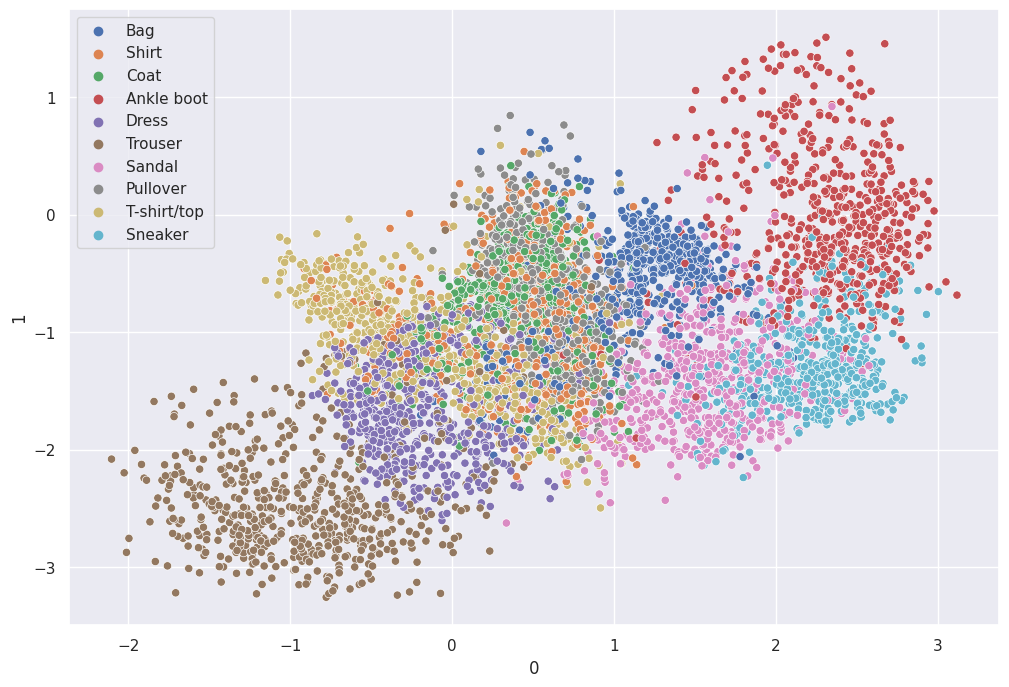

In [13]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.scatterplot(data=pd.DataFrame(embeddings_arr), x=0, y=1, hue=labels)

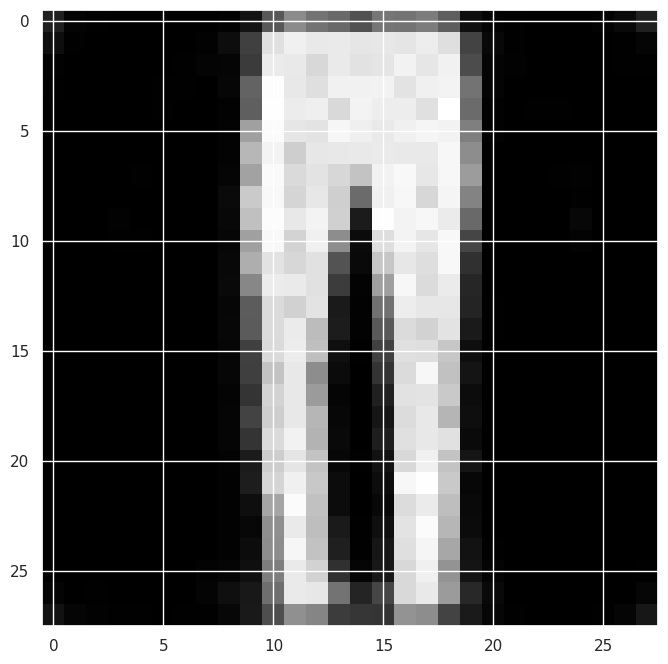

In [20]:
coord = [-2, -3]
prediction = model.decoder(torch.tensor([coord], dtype=torch.float32))
img = T.functional.to_pil_image(prediction.squeeze(0).squeeze(0))
plt.imshow(img, cmap='gray')